In [11]:
%load_ext nb_black

import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15, 15)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

import pandas as pd

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
IB_METHODS = ["read", "write", "send"]

<IPython.core.display.Javascript object>

In [3]:
dfs = {}

for method in IB_METHODS:
    print(method)
    with open(f"raw/softroce_multi_vdev/ib_{method}_bw.txt") as f:
        raw_bw_data = f.read().strip().split("\n")

    raw_bw_data = [r.split("\t") for r in raw_bw_data]
    bw_data = (
        pd.DataFrame(columns=raw_bw_data[0], data=raw_bw_data[1:])
        .set_index("#pairs")
        .astype({"Agg BW average[MB/sec]": "float64", "Agg MsgRate[Mpps]": "float64"})
    )

    with open(f"raw/softroce_multi_vdev/{method}_cpu_client.txt") as f:
        raw_cpu_cl_data = f.read().strip().split("\n")

    raw_cpu_cl_data = [r.split("\t") for r in raw_cpu_cl_data]
    cpu_cl_data = (
        pd.DataFrame(columns=raw_cpu_cl_data[0], data=raw_cpu_cl_data[1:])
        .set_index("#pairs")
        .astype({"CPU Usage %": "float64"})
        .rename(columns={"CPU Usage %": "Client CPU Usage %"})
    )

    with open(f"raw/softroce_multi_vdev/{method}_cpu_server.txt") as f:
        raw_cpu_serv_data = f.read().strip().split("\n")

    raw_cpu_serv_data = [r.split("\t") for r in raw_cpu_serv_data]
    cpu_serv_data = (
        pd.DataFrame(columns=raw_cpu_serv_data[0], data=raw_cpu_serv_data[1:])
        .set_index("#pairs")
        .astype({"CPU Usage %": "float64"})
        .rename(columns={"CPU Usage %": "Server CPU Usage %"})
    )

    df = pd.concat([bw_data, cpu_cl_data, cpu_serv_data], axis=1)
    print(df.head(), "\n")

    dfs[method] = df

read
        Agg BW average[MB/sec]  Agg MsgRate[Mpps]  \
#pairs                                              
1                      1260.54           0.020169   
2                      1884.04           0.030145   
3                      2615.14           0.041842   
4                      3373.67           0.053978   
5                      4262.50           0.068199   

                       BW averages[MB/sec]  \
#pairs                                       
1                                  1260.54   
2                            916.00,968.04   
3                     868.89,897.24,849.01   
4              870.38,855.03,789.09,859.17   
5       860.94,851.77,775.86,850.09,923.84   

                                      MsgRates[Mpps]  Client CPU Usage %  \
#pairs                                                                     
1                                           0.020169              197.12   
2                                  0.014656,0.015489              354.56

<IPython.core.display.Javascript object>

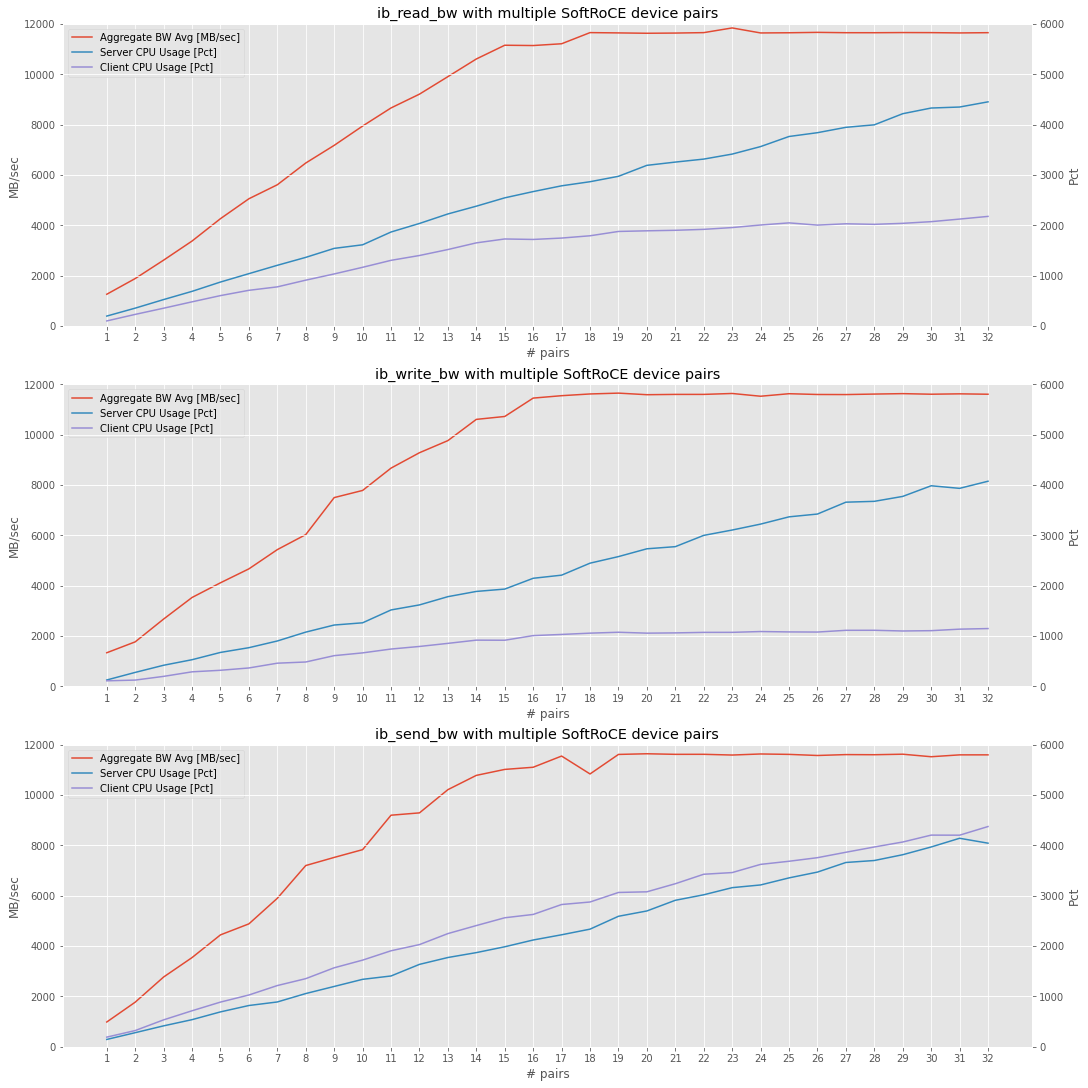

<IPython.core.display.Javascript object>

In [14]:
fig, axs = plt.subplots(len(dfs), 1, layout="constrained")
idx = 0

for method, df in dfs.items():
    ax = axs[idx]

    twin1 = ax.twinx()

    (p1,) = ax.plot(
        df.index,
        df["Agg BW average[MB/sec]"],
        color=colors[0],
        label="Aggregate BW Avg [MB/sec]",
    )
    (p2,) = twin1.plot(
        df.index,
        df["Client CPU Usage %"],
        color=colors[1],
        label="Server CPU Usage [Pct]",
    )
    (p3,) = twin1.plot(
        df.index,
        df["Server CPU Usage %"],
        color=colors[2],
        label="Client CPU Usage [Pct]",
    )

    ax.set_ylim(0, 12000)
    twin1.set_ylim(0, 6000)

    ax.set_xlabel("# pairs")
    ax.set_ylabel("MB/sec")
    twin1.set_ylabel("Pct")

    ax.legend(handles=[p1, p2, p3])
    ax.set_title(f"ib_{method}_bw with multiple SoftRoCE device pairs")

    idx += 1

plt.savefig("softroce_multi_vdevs.png")
plt.show()